In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install imbalanced-learn==0.10.1
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import resample

import imblearn
from imblearn.under_sampling import NearMiss, RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

from collections import Counter
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.2 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [2]:
def feature_engineering(df):
    df = df.copy()

    # 1. Log transform on TransactionAmt
    df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])

    # 2. Missing value count feature
    df['nulls'] = df.isnull().sum(axis=1)

    # 3. Frequency encoding for key categorical features
    freq_encode_cols = ['card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'ProductCD', 'card4', 'card6', 'DeviceType']
    for col in freq_encode_cols:
        if col in df.columns:
            df[col + '_freq'] = df[col].map(df[col].value_counts(dropna=False))

    # 4. Groupby aggregation features on TransactionAmt
    if 'card1' in df.columns:
        df['card1_TransactionAmt_mean'] = df.groupby('card1')['TransactionAmt'].transform('mean')
        df['card1_TransactionAmt_std'] = df.groupby('card1')['TransactionAmt'].transform('std')

    if 'addr1' in df.columns:
        df['addr1_TransactionAmt_mean'] = df.groupby('addr1')['TransactionAmt'].transform('mean')
        df['addr1_TransactionAmt_std'] = df.groupby('addr1')['TransactionAmt'].transform('std')

    # 5. Time features from TransactionDT
    if 'TransactionDT' in df.columns:
        df['hour'] = (df['TransactionDT'] // 3600) % 24
        df['day'] = df['TransactionDT'] // (3600 * 24)
        df['weekday'] = df['day'] % 7
        df['hour_bin'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=[0,1,2,3], include_lowest=True)
        df['is_weekend'] = (df['weekday'] >= 5).astype(int)

    # 6. Email domain simplification
    def simplify_email(x):
        x = str(x).lower()
        if 'gmail' in x:
            return 'gmail'
        elif 'yahoo' in x:
            return 'yahoo'
        elif 'hotmail' in x:
            return 'hotmail'
        elif 'outlook' in x:
            return 'outlook'
        elif pd.isna(x) or x in ['nan', '']:
            return 'unknown'
        else:
            return 'others'

    for col in ['P_emaildomain', 'R_emaildomain']:
        if col in df.columns:
            df[col + '_simple'] = df[col].apply(simplify_email)
            df[col + '_simple'] = LabelEncoder().fit_transform(df[col + '_simple'])

    # 7. Device info parsing
    if 'DeviceInfo' in df.columns:
        df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown').str.lower()
        df['Device_brand'] = df['DeviceInfo'].str.extract('([a-zA-Z]+)').fillna('unknown')
        df['Device_brand'] = LabelEncoder().fit_transform(df['Device_brand'])

    # 8. Binary indicator for mobile device
    if 'DeviceType' in df.columns:
        df['is_mobile'] = (df['DeviceType'] == 'mobile').astype(int)

    # 9. Categorical combinations + frequency
    if 'card1' in df.columns and 'card4' in df.columns:
        df['card1_card4'] = df['card1'].astype(str) + '_' + df['card4'].astype(str)
        df['card1_card4_freq'] = df['card1_card4'].map(df['card1_card4'].value_counts())

    if 'addr1' in df.columns and 'P_emaildomain' in df.columns:
        df['addr1_email'] = df['addr1'].astype(str) + '_' + df['P_emaildomain'].astype(str)
        df['addr1_email_freq'] = df['addr1_email'].map(df['addr1_email'].value_counts())

    return df


In [3]:
results = []

def evaluate_model(name, model, X_test, y_test, y_pred_prob=None):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if y_pred_prob is None else y_pred_prob
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'y_test': y_test,               # For curve drawing
        'y_proba': y_proba              # For curve drawing
    })


results_addition = []

def evaluate_model2(name, model, X_test, y_test, y_pred_prob=None):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if y_pred_prob is None else y_pred_prob
    
    results_addition.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_proba),
        'y_test': y_test,               # For curve drawing
        'y_proba': y_proba              # For curve drawing
    })

In [4]:
o_transactions=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID')
o_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv',index_col='TransactionID')

print('Train data set is loaded !')

Train data set is loaded !


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


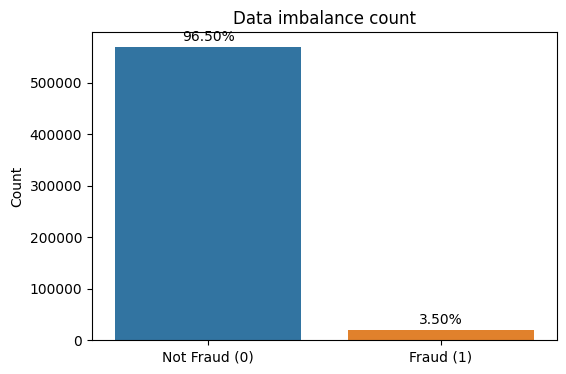

In [5]:
x = o_transactions['isFraud'].value_counts()
labels = ['Not Fraud (0)', 'Fraud (1)']
total = x.sum()
percentages = [f'{(count/total)*100:.2f}%' for count in x.values]

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=x.values)
plt.title('Data imbalance count')
plt.ylabel('Count')

for i, value in enumerate(x.values):
    plt.text(i, value + total*0.01, percentages[i], ha='center', va='bottom', fontsize=10)

plt.show()

In [6]:
o_data = o_transactions.merge(o_identity, how='left', left_index=True, right_index=True)
print(f'Original dataset has {o_data.shape[0]} rows and {o_data.shape[1]} columns.')

Original dataset has 590540 rows and 433 columns.


In [7]:
o_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 1.9+ GB


In [8]:
o_data.head()
print(f'There are {o_data.isnull().any().sum()} columns in original dataset with missing values.')
y = o_data['isFraud']
X = o_data.drop('isFraud', axis=1)
del o_transactions, o_identity

There are 414 columns in original dataset with missing values.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


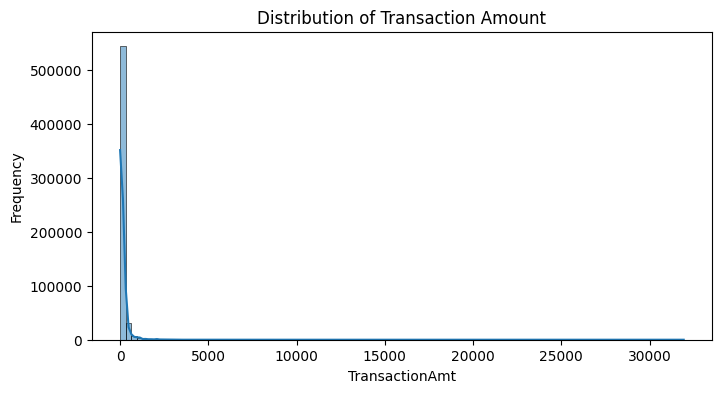

In [9]:

plt.figure(figsize=(8, 4))
sns.histplot(o_data['TransactionAmt'], bins=100, kde=True)
plt.title('Distribution of Transaction Amount')
plt.xlabel('TransactionAmt')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


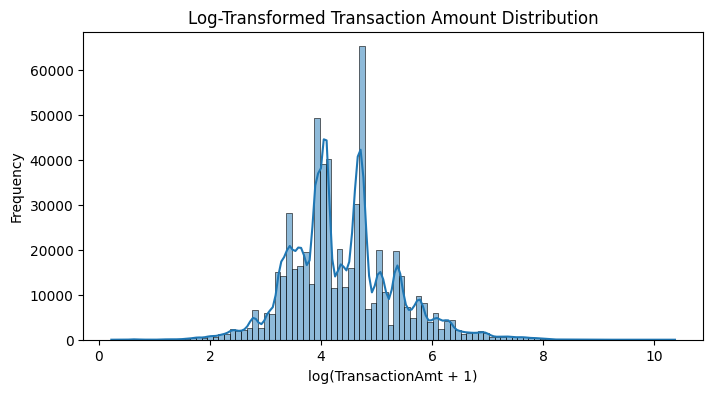

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(np.log1p(o_data['TransactionAmt']), bins=100, kde=True)
plt.title('Log-Transformed Transaction Amount Distribution')
plt.xlabel('log(TransactionAmt + 1)')
plt.ylabel('Frequency')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


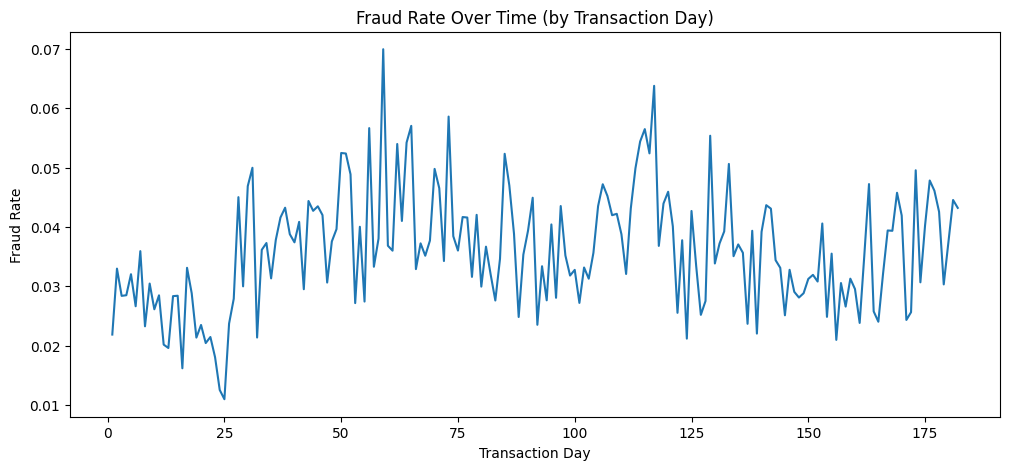

In [11]:
o_data['Transaction_day'] = o_data['TransactionDT'] // (3600 * 24)

plt.figure(figsize=(12, 5))
sns.lineplot(data=o_data.groupby('Transaction_day')['isFraud'].mean().reset_index(),
             x='Transaction_day', y='isFraud')
plt.title('Fraud Rate Over Time (by Transaction Day)')
plt.xlabel('Transaction Day')
plt.ylabel('Fraud Rate')
plt.show()

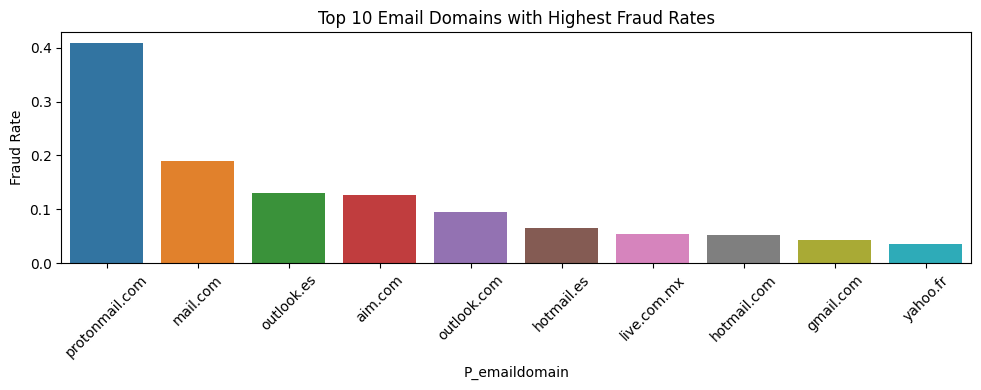

In [12]:
email_fraud_rate = o_data.groupby('P_emaildomain')['isFraud'].mean().sort_values(ascending=False)[:10]

plt.figure(figsize=(10, 4))
sns.barplot(x=email_fraud_rate.index, y=email_fraud_rate.values)
plt.title('Top 10 Email Domains with Highest Fraud Rates')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

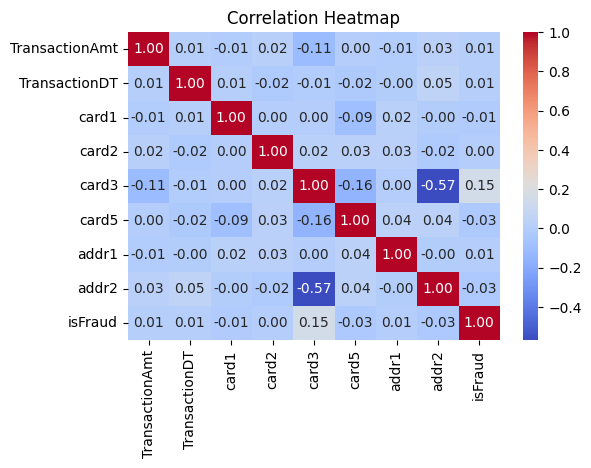

In [13]:
corr_cols = ['TransactionAmt','TransactionDT', 'card1', 'card2', 'card3', 'card5','addr1','addr2','isFraud']
corr = o_data[corr_cols].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [14]:
# Initial filling to avoid feature engineering errors
X = X.fillna(-999)

# feature engineering
X_fe = feature_engineering(X)

# Check again for missing values
print(f'There are {X_fe.isnull().any().sum()} columns with missing values after feature engineering.')

# Handle missing values uniformly for all columns
for col in X_fe.columns:
    if X_fe[col].isnull().any():
        if X_fe[col].dtype in ['float64', 'int64']:
            X_fe[col] = X_fe[col].fillna(-999)
        else:
            X_fe[col] = X_fe[col].fillna('missing')

# Encode all non-numeric columns
for col in X_fe.columns:
    if X_fe[col].dtype == 'object' or isinstance(X_fe[col].dtype, pd.CategoricalDtype):
        le = LabelEncoder()
        X_fe[col] = le.fit_transform(X_fe[col].astype(str))

There are 3 columns with missing values after feature engineering.


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_fe, y, test_size=0.2, random_state=42, stratify=y)
X_test_gpu = cp.array(X_test)  # Convert to GPU data
y_train.info()

<class 'pandas.core.series.Series'>
Index: 472432 entries, 3027809 to 3324290
Series name: isFraud
Non-Null Count   Dtype
--------------   -----
472432 non-null  int64
dtypes: int64(1)
memory usage: 7.2 MB


In [17]:
clf_ori = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    scale_pos_weight=19,
    reg_alpha=0.1,
    reg_lambda=1,
    eval_metric='auc'
)

# no sampling
clf_ori.fit(X_train, y_train)

evaluate_model("Original", clf_ori, X_test_gpu, y_test)
print(results)

[{'Model': 'Original', 'Accuracy': 0.9719494022420158, 'Precision': 0.5681289464938518, 'Recall': 0.827244132591338, 'F1': 0.6736282139690671, 'AUC': 0.9721683376280035, 'y_test': TransactionID
3303078    0
3103888    0
3397211    0
3238027    0
3178265    0
          ..
3106307    0
3132129    1
3487536    0
3242768    1
3043935    0
Name: isFraud, Length: 118108, dtype: int64, 'y_proba': array([0.04254812, 0.09459493, 0.02161151, ..., 0.17500867, 0.36854294,
       0.01141398], dtype=float32)}, {'Model': 'Original', 'Accuracy': 0.9775967758322891, 'Precision': 0.6428434197886648, 'Recall': 0.8095814178562787, 'F1': 0.7166416791604199, 'AUC': 0.9715570655821166, 'y_test': TransactionID
3303078    0
3103888    0
3397211    0
3238027    0
3178265    0
          ..
3106307    0
3132129    1
3487536    0
3242768    1
3043935    0
Name: isFraud, Length: 118108, dtype: int64, 'y_proba': array([0.026307  , 0.07720448, 0.04942282, ..., 0.11521968, 0.21594945,
       0.00595739], dtype=float32

In [ ]:
clf_NearMiss = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    reg_alpha=0.1,
    reg_lambda=1,
    n_jobs=1,
    eval_metric='auc'
)

# Undersampling-NearMiss
nm = NearMiss(version=1)
X_resampled1, y_resampled1 = nm.fit_resample(X_train, y_train)
clf_NearMiss.fit(X_resampled1, y_resampled1)

evaluate_model("NearMiss", clf_NearMiss, X_test_gpu, y_test)
print(results)

In [ ]:
clf_RUS_TL = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    reg_alpha=0.1,
    reg_lambda=1,
    n_jobs=1,
    eval_metric='auc'
)

# Undersampling-RandomUnderSampler+TomekLinks
under_pipeline = Pipeline([
    ('under', RandomUnderSampler(sampling_strategy=1.0, random_state=42)),
    ('tomek', TomekLinks(sampling_strategy='auto'))
])

X_resampled2, y_resampled2 = under_pipeline.fit_resample(X_train, y_train)
clf_RUS_TL.fit(X_resampled2, y_resampled2)

evaluate_model("RUS+tomek", clf_RUS_TL, X_test_gpu, y_test)
print(results)

In [ ]:
clf_SMOTE = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    reg_alpha=0.1,
    reg_lambda=1,
    n_jobs=1,
    eval_metric='auc'
)

# oversampling-SMOTE
smote = SMOTE(random_state=42)
X_resampled3, y_resampled3 = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_resampled3))

clf_SMOTE.fit(X_resampled3, y_resampled3)


In [ ]:
evaluate_model("SMOTE", clf_SMOTE, X_test_gpu, y_test)
print(results)

In [ ]:
clf_SMOTE_tomek = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    reg_alpha=0.1,
    reg_lambda=1,
    n_jobs=1,
    eval_metric='auc'
)

smote_tomek=SMOTETomek(random_state=42)
X_train_small = X_train.sample(n=120000, random_state=42)
y_train_small = y_train.loc[X_train_small.index]
X_resampled4, y_resampled4 = smote_tomek.fit_resample(X_train_small, y_train_small)
print("Class distribution after SMOTE + TomekLinks:", Counter(y_resampled4))

clf_SMOTE_tomek.fit(X_resampled4, y_resampled4)

In [ ]:
evaluate_model("SMOTETomek", clf_SMOTE_tomek, X_test_gpu, y_test)
print(results)

In [ ]:
clf_SMOTE_small = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2019,
    tree_method='hist',
    device='cuda',  
    reg_alpha=0.1,
    reg_lambda=1,
    n_jobs=1,
    eval_metric='auc'
)

# oversampling-SMOTE
smote = SMOTE(random_state=42)
X_resampled5, y_resampled5 = smote.fit_resample(X_train_small, y_train_small)
print("Class distribution after SMOTE:", Counter(y_resampled5))

clf_SMOTE_small.fit(X_resampled5, y_resampled5)

In [ ]:
evaluate_model2("SMOTETomek", clf_SMOTE_tomek, X_test_gpu, y_test)

evaluate_model2("SMOTE_small", clf_SMOTE_small, X_test_gpu, y_test)
print(results_addition)

In [ ]:
df_results = pd.DataFrame(results)
df_results.to_csv("model_comparison_results.csv", index=False)

In [ ]:
df_results_addition = pd.DataFrame(results_addition)
df_results_addition.to_csv("addition_model_comparison_results.csv", index=False)

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
for metric in metrics:
    plt.figure(figsize=(7, 5))
    ax = sns.barplot(x='Model', y=metric, data=df_results)

    # Add value labels above the bar chart
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='center', padding=3)

    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
for r in results:
    fpr, tpr, _ = roc_curve(r['y_test'], r['y_proba'])
    plt.plot(fpr, tpr, label=f"ROC - {r['Model']}")
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [ ]:
for r in results:
    precision, recall, _ = precision_recall_curve(r['y_test'], r['y_proba'])
    plt.plot(recall, precision, label=f"PR - {r['Model']}")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [ ]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
for metric in metrics:
    plt.figure(figsize=(6, 4))
    ax2=sns.barplot(x='Model', y=metric, data=df_results_addition)
    
    # Add value labels above the bar chart
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.3f', label_type='center', padding=3)
    
    plt.title(f'{metric} Comparison')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

In [ ]:
for r in results_addition:
    fpr, tpr, _ = roc_curve(r['y_test'], r['y_proba'])
    plt.plot(fpr, tpr, label=f"ROC - {r['Model']}")
plt.title("ROC Curve Comparison")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [ ]:
for r in results_addition:
    precision, recall, _ = precision_recall_curve(r['y_test'], r['y_proba'])
    plt.plot(recall, precision, label=f"PR - {r['Model']}")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()